In [7]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset. 
# implemented Simple Ensemble Learning methods Max Voting  

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.calibration import LabelEncoder
import tensorflow as tf
import seaborn as sns

In [8]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv(
    '/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl_cleaned_dataset.csv')

In [9]:
# df = df.sample(frac=0.75)

In [10]:
# Extract subsample of data
print(" Extract subsample of data: ")
print(df['ALERT'].value_counts())

 Extract subsample of data: 
ALERT
Normal               15049330
Denial of Service     5138973
Port Scanning         4170194
Malware                   571
Name: count, dtype: int64


In [11]:
dropped_df = ['ALERT']
X = df.drop(dropped_df, axis=1)
y = df['ALERT']

# Label encoding for the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(df['ALERT'].value_counts())

ALERT
Normal               15049330
Denial of Service     5138973
Port Scanning         4170194
Malware                   571
Name: count, dtype: int64


In [12]:
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Standardize numerical features (if applicable)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

# Train the models
with strategy.scope():
    # Initialize the three models
    Knn_model = KNeighborsClassifier()
    dt_model = DecisionTreeClassifier(random_state=1)
    rf_model = RandomForestClassifier(random_state=1)

    # initialize the voting classifier and specify the voting type to be hard voting
    # the estimator parameter is a list containing the three models we have initialized
    Vot_model = VotingClassifier(
        estimators=[('knn', Knn_model), ('dt', dt_model), ('rf' , rf_model)], voting='hard')

    Vot_model.fit(X_train, y_train)
    Vot_model.score(X_test, y_test)
    


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-03 03:27:39.063877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1046 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-03-03 03:27:39.087711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1047 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6


In [13]:
# Make predictions on the test set
y_pred_encoded = Vot_model.predict(X_test)


In [14]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [15]:
# Use inverse_transform to get original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test)

In [16]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00   1027795
          Malware       1.00      1.00      1.00       114
           Normal       1.00      1.00      1.00   3009866
    Port Scanning       1.00      1.00      1.00    834039

         accuracy                           1.00   4871814
        macro avg       1.00      1.00      1.00   4871814
     weighted avg       1.00      1.00      1.00   4871814



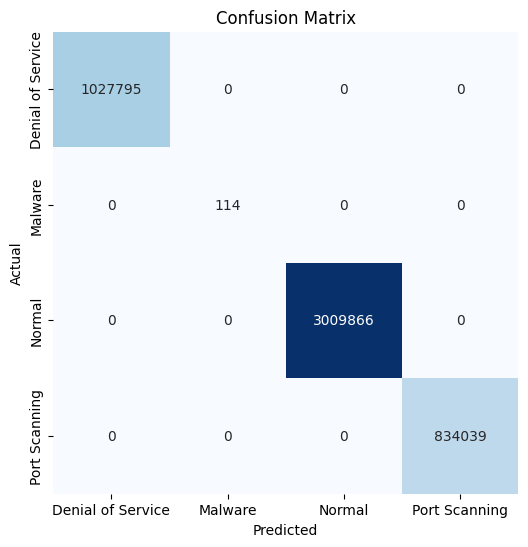

In [17]:
import numpy as np
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred)

# Get unique class labels from y_test and y_pred
unique_labels = np.unique(np.concatenate((y_test_labels, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_2292635/3885283476.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_importance.values()), y=list(


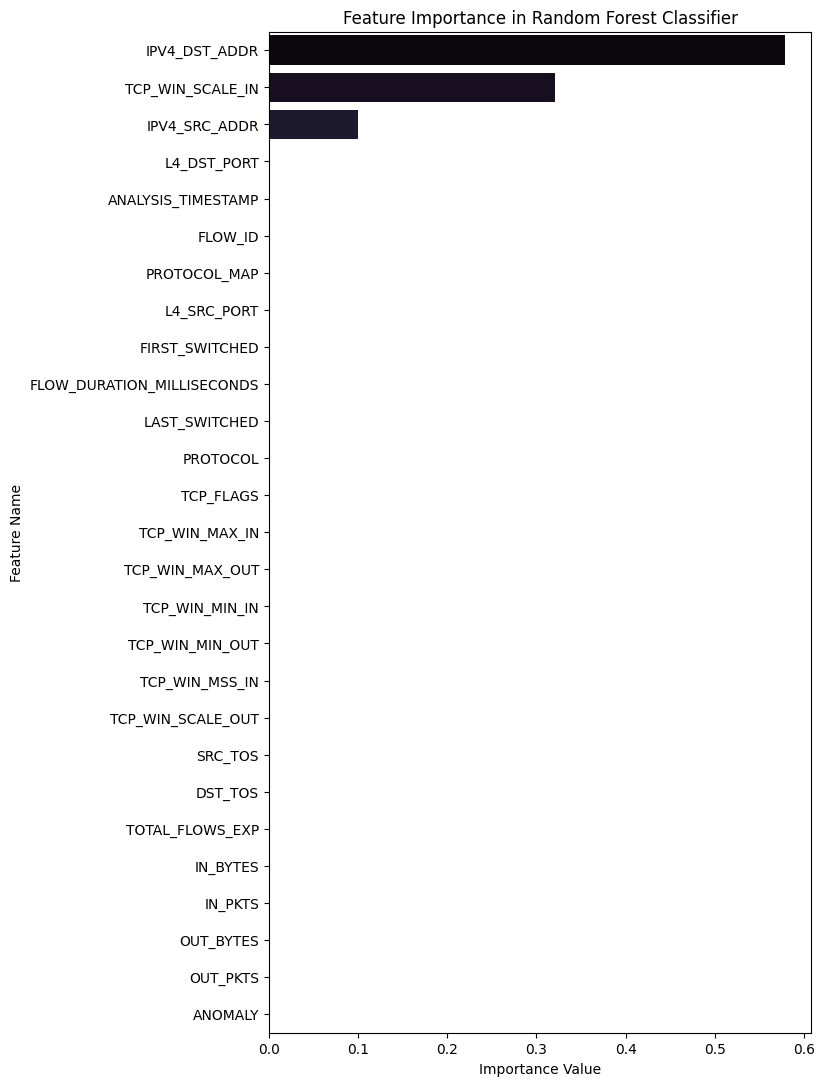

In [18]:
# importances of features in the decision tree model
importance = Vot_model.estimators_[1].feature_importances_
importance_dict = dict(zip(X.columns.values, importance))
sorted_importance = dict(
    sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(7, 13))
sns.barplot(x=list(sorted_importance.values()), y=list(
    sorted_importance.keys()), palette='cubehelix')
plt.xlabel('Importance Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()